In [2]:
from datetime import datetime

# SecureString parameter stored in AWS System Manager that holds a GitHub personal access token.
parameter_name = 'github_token'

# Repositories for which reports will be generated.
repo_names = [
    # Android
    'aws-amplify/amplify-android',
    'aws-amplify/aws-sdk-android',
    'awslabs/aws-mobile-appsync-sdk-android',

    # iOS
    'aws-amplify/amplify-ios',
    'aws-amplify/aws-sdk-ios',
    'awslabs/aws-mobile-appsync-sdk-ios',
    
    # JS
    'aws-amplify/amplify-js',
    
    # CLI
    'aws-amplify/amplify-cli',
]

# Labels used across different repositories
issue_buckets = {
    'Bug': ['Bug', 'bug'],
    'Feature Request': ['Improvement', 'Feature Request', 'enhancement', 'feature-request'],
    'Question': ['Usage Question', 'Question', 'question'],
    'Pending Triage': ['Pending Triage', 'to-be-reproduced']
}

# Labels to omit from rows
omit_labels = {
    'Wont Fix', "Won't Fix", 'closing-soon-if-no-response', 'Product Review',
    'Requesting Feedback', 'Closing Soon', 'Clarification Needed', 'Duplicate',
    'Needs Info from Requester', 'work-in-progress', 'good-first-issue',
    'pending-close-response-required', 'pending-response', 'pending-release',
    'Awaiting Release', 'Investigating', 'Pending', 'Pull Request', 'duplicate',
    'good first issue', 'Reviewing', 'needs review', 'needs discussion',
    'needs-review', 'investigating', 'help wanted', 'needs-discussion',
    'Help Wanted', 'Good First Issue', 'wontfix'
}
omit_labels = omit_labels.union({label for labels in issue_buckets.values() for label in labels})

# Capture start time
start = datetime.now()

In [3]:
# Retrieve the GitHub token from SSM to prevent oops-I-pushed-credentials-to-GitHub uh-ohs.

import boto3

ssm = boto3.client('ssm')
response = ssm.get_parameter(Name=parameter_name, WithDecryption=True)
token = response['Parameter']['Value']

In [4]:
# Grab all issues from the GitHub V4 GraphQL API

import requests
import json

headers = {'Authorization': f'Bearer {token}'}


def get_issues(owner, name, *, end_cursor=None):
    query = """
    query($owner: String!, $name: String!, $endCursor: String) {
      repository(owner:$owner, name:$name) {
        issues(first:100, after:$endCursor) {
          nodes {
            number
            title
            createdAt
            closedAt
            reactions {
              totalCount
            }
            comments(first:100) {
              nodes {
                createdAt
                author {
                  login
                }
                reactions {
                  totalCount
                }
              }
            }
            labels(first:3) {
              nodes {
                name
              }
            }
          }
          pageInfo {
            hasNextPage
            endCursor
          }
        }
      }
    }"""
    
    variables = {'owner': owner, 'name': name, 'endCursor': end_cursor}
    response = execute(query, variables)
    page_info = response['data']['repository']['issues']['pageInfo']
    nodes = response['data']['repository']['issues']['nodes']
    
    for issue in nodes:
        yield issue
    
    if page_info['hasNextPage']:
        yield from get_issues(owner, name, end_cursor=page_info['endCursor'])
    
def execute(query, variables):
    request = requests.post(
        'https://api.github.com/graphql',
        json={'query': query, 'variables': variables},
        headers=headers
    )

    if request.status_code == 200:
        return request.json()
    else:
        raise Exception("{}: {}".format(request.status_code, query))

In [5]:
# Loop through each repository, grab all issues, and create a DataFrame for each.

import pandas as pd

repos = {}
bucket_lookup = {label: bucket for bucket, labels in issue_buckets.items() for label in labels}

for repo_name in repo_names:
    issues = []
    owner, name = repo_name.split('/')

    for issue in get_issues(owner, name):
        labels = pd.array([label['name'] for label in issue['labels']['nodes']])
        bucket = 'Other'
        created_at = pd.Timestamp(issue['createdAt'],tz='UTC')
        
        score = 1
        score += len(issue['comments']) 
        score += issue['reactions']['totalCount']
        score += sum(comment['reactions']['totalCount'] for comment in issue['comments']['nodes'])
        
        if issue['closedAt']:
            closed_at = pd.Timestamp(issue['closedAt'], tz='UTC')
        else:
            closed_at = None
            
        for label in labels:
            if label in bucket_lookup:
                bucket = bucket_lookup[label]
                break
                
        issues.append(
            [issue['number'], issue['title'], labels, created_at, closed_at, bucket, score]
        )
        
    repos[repo_name] = pd.DataFrame(issues, columns=[
        'id', 'title', 'labels', 'created_at', 'closed_at', 'bucket', 'score'
    ])

In [6]:
# Utility function to generate statistics (counts, MoM, WoW, etc) for a DataFrame.

import pytz
from datetime import datetime


def generate_stats(df):
    utc = pytz.timezone('UTC')

    seven_days_ago = datetime.now() - pd.Timedelta('7 days')
    seven_days_ago = seven_days_ago.astimezone(utc)

    thirty_days_ago = datetime.now() - pd.Timedelta('30 days')
    thirty_days_ago = thirty_days_ago.astimezone(utc)

    open_issues = df[~(df.closed_at > '1970-01-01')]
    last_week_closed_issues = df[(df.closed_at > seven_days_ago)]
    last_month_closed_issues = df[(df.closed_at > thirty_days_ago)]
    last_week_open_issues = df[(df.created_at < seven_days_ago) & ~(df.closed_at < seven_days_ago)]
    last_month_open_issues = df[(df.created_at < thirty_days_ago) & ~(df.closed_at < thirty_days_ago)]
    
    open_issues_count = len(open_issues.index)
    last_week_closed_issues_count = len(last_week_closed_issues.index)
    last_month_closed_issues_count = len(last_month_closed_issues.index)
    last_week_open_issues_count = len(last_week_open_issues.index)
    last_month_open_issues_count = len(last_month_open_issues.index)
    
    return [
        open_issues_count,
        last_week_open_issues_count,
        open_issues_count - last_week_open_issues_count,
        last_month_open_issues_count,
        open_issues_count - last_month_open_issues_count,
        last_week_closed_issues_count,
        last_month_closed_issues_count
    ]

In [7]:
# Using the DataFrames, process and grab the counts of issues by repo and then by bucket.

import pandas as pd
from IPython.display import display, HTML

pd.set_option('display.max_rows', 500)

for repo_name in repo_names:
    df = repos[repo_name]
    buckets = {bucket for bucket in df.bucket}
    
    row = [repo_name]
    row.extend(generate_stats(df))

    open_df = pd.DataFrame([row], columns=[
        'Repo', 'Open', 'Last Week', 'WoW', 'Last Month', 'MoM', 'Closed Last Week',
        'Closed Last Month'
    ])
    
    display(HTML(f'<h1>{repo_name}</h1>'))
    display(open_df)
    
    for bucket in sorted(buckets):
        bucket_counts = []
        issues = df.loc[df.bucket == bucket]
        labels = {label for labels in issues.labels for label in labels}
        row = [bucket, '']

        row.extend(generate_stats(issues))
        bucket_counts.append(row)
        
        for label in sorted(labels):
            if label in omit_labels or label in buckets:
                continue
            
            label_mask = issues.labels.apply(lambda l: label in l)
            label_issues = issues[label_mask]
            stats = generate_stats(label_issues)
            
            if sum(stats): 
                row = [bucket, label]
                row.extend(stats)
                bucket_counts.append(row)

        bucket_df = pd.DataFrame(bucket_counts, columns=[
            'Bucket', 'Label', 'Open', 'Last Week', 'WoW', 'Last Month', 'MoM',
            'Closed Last Week', 'Closed Last Month'
        ])
        
        display(HTML(f'<h2>{repo_name}: {bucket}'))
        display(bucket_df)

    display(HTML(f'<hr>'))

,Repo,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,aws-amplify/amplify-android,18,20,-2,15,3,2,8


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Bug,,6,6,0,6,0,0,1
1,Bug,API,5,5,0,4,1,0,0
2,Bug,DataStore,1,1,0,2,-1,0,1


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Feature Request,,11,12,-1,9,2,1,2
1,Feature Request,API,3,3,0,3,0,0,0
2,Feature Request,Core,1,1,0,1,0,0,0
3,Feature Request,DataStore,4,4,0,3,1,0,1
4,Feature Request,Documentation,1,2,-1,1,0,1,1
5,Feature Request,Infrastructure,1,1,0,1,0,0,0


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Other,,0,1,-1,0,0,1,2
1,Other,CLI,0,1,-1,0,0,1,1
2,Other,DataStore,0,1,-1,0,0,1,1


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Pending Triage,,1,1,0,0,1,0,1
1,Pending Triage,DataStore,1,1,0,0,1,0,1


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Question,,0,0,0,0,0,0,2
1,Question,DataStore,0,0,0,0,0,0,2


,Repo,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,aws-amplify/aws-sdk-android,128,123,5,133,-5,1,27


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Bug,,27,26,1,33,-6,0,11
1,Bug,AWSMobileClient,7,7,0,7,0,0,1
2,Bug,AppSync,1,1,0,1,0,0,0
3,Bug,Cognito,5,5,0,6,-1,0,3
4,Bug,Core,2,2,0,3,-1,0,1
5,Bug,IoT,2,2,0,4,-2,0,3
6,Bug,KinesisVideo,2,2,0,2,0,0,0
7,Bug,Lambda,3,2,1,1,2,0,0
8,Bug,Pinpoint,3,3,0,3,0,0,0
9,Bug,S3,1,1,0,5,-4,0,4


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Feature Request,,65,64,1,65,0,0,5
1,Feature Request,APIGateway,1,1,0,1,0,0,0
2,Feature Request,AWSMobileClient,15,15,0,16,-1,0,1
3,Feature Request,Cognito,16,16,0,17,-1,0,1
4,Feature Request,Core,5,5,0,5,0,0,0
5,Feature Request,Documentation,1,1,0,1,0,0,0
6,Feature Request,IoT,12,11,1,11,1,0,1
7,Feature Request,KinesisVideo,1,1,0,1,0,0,0
8,Feature Request,Lambda,1,1,0,1,0,0,0
9,Feature Request,Other AWS Services,2,2,0,1,1,0,0


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Other,,10,9,1,13,-3,1,7
1,Other,AWSMobileClient,3,3,0,3,0,0,0
2,Other,Amplify CLI,0,0,0,1,-1,0,1
3,Other,Cognito,1,1,0,2,-1,0,1
4,Other,DynamoDB,1,1,0,1,0,0,0
5,Other,IoT,2,2,0,2,0,0,0
6,Other,Pinpoint,0,0,0,1,-1,0,1
7,Other,S3,0,0,0,1,-1,0,1
8,Other,SNS,0,0,0,1,-1,0,1
9,Other,Sample App,1,1,0,2,-1,0,1


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Pending Triage,,1,1,0,0,1,0,0
1,Pending Triage,S3,1,1,0,0,1,0,0


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Question,,25,23,2,22,3,0,4
1,Question,APIGateway,3,3,0,3,0,0,0
2,Question,AWSMobileClient,9,8,1,6,3,0,2
3,Question,Cognito,5,4,1,2,3,0,0
4,Question,Core,2,2,0,2,0,0,0
5,Question,Documentation,1,1,0,1,0,0,0
6,Question,DynamoDB,0,0,0,1,-1,0,1
7,Question,IoT,2,2,0,2,0,0,0
8,Question,KinesisVideo,1,1,0,1,0,0,0
9,Question,Pinpoint,2,2,0,2,0,0,0


,Repo,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,awslabs/aws-mobile-appsync-sdk-android,47,46,1,44,3,0,2


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Bug,,17,17,0,16,1,0,0
1,Bug,AppSync,16,16,0,16,0,0,0
2,Bug,Codegen,2,2,0,2,0,0,0
3,Bug,Documentation,1,1,0,1,0,0,0


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Feature Request,,13,13,0,14,-1,0,1
1,Feature Request,AppSync,12,12,0,13,-1,0,1
2,Feature Request,Codegen,1,1,0,1,0,0,0


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Other,,8,7,1,4,4,0,0
1,Other,AppSync,3,3,0,3,0,0,0
2,Other,Codegen,1,1,0,1,0,0,0
3,Other,Infrastructure,1,1,0,1,0,0,0


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Question,,9,9,0,10,-1,0,1
1,Question,AppSync,9,9,0,10,-1,0,1
2,Question,Documentation,1,1,0,1,0,0,0
3,Question,Infrastructure,1,1,0,1,0,0,0


,Repo,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,aws-amplify/amplify-ios,63,62,1,55,8,1,4


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Bug,,15,15,0,14,1,0,0
1,Bug,API,2,2,0,2,0,0,0
2,Bug,Analytics,1,1,0,0,1,0,0
3,Bug,Codable Enums,2,2,0,2,0,0,0
4,Bug,Core,1,1,0,1,0,0,0
5,Bug,DataStore,9,9,0,9,0,0,0
6,Bug,P0,1,1,0,1,0,0,0
7,Bug,Storage,2,2,0,2,0,0,0
8,Bug,documentation,1,1,0,1,0,0,0


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Feature Request,,16,16,0,14,2,0,0
1,Feature Request,Core,4,4,0,4,0,0,0
2,Feature Request,DataStore,10,10,0,9,1,0,0
3,Feature Request,P0,4,4,0,4,0,0,0
4,Feature Request,Storage,1,1,0,1,0,0,0


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Other,,31,30,1,26,5,1,4
1,Other,API,6,6,0,6,0,0,0
2,Other,Analytics,0,1,-1,1,-1,1,2
3,Other,Build,2,2,0,3,-1,0,2
4,Other,Codable Enums,1,1,0,1,0,0,0
5,Other,Core,2,2,0,2,0,0,0
6,Other,DataStore,16,16,0,16,0,0,1
7,Other,P0,2,2,0,2,0,0,0
8,Other,P1,1,1,0,1,0,0,0
9,Other,amplify-app,2,2,0,1,1,0,0


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Question,,1,1,0,1,0,0,0
1,Question,DataStore,1,1,0,1,0,0,0


,Repo,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,aws-amplify/aws-sdk-ios,184,179,5,193,-9,0,26


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Bug,,37,37,0,37,0,0,2
1,Bug,APIGateway,1,1,0,1,0,0,0
2,Bug,AWSMobileClient,7,7,0,6,1,0,0
3,Bug,AppSync,2,2,0,2,0,0,0
4,Bug,Cognito,5,5,0,5,0,0,0
5,Bug,Core,1,1,0,1,0,0,0
6,Bug,Documentation,1,1,0,1,0,0,0
7,Bug,IoT,11,11,0,12,-1,0,1
8,Bug,Pinpoint,2,2,0,2,0,0,1
9,Bug,S3,10,10,0,10,0,0,0


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Feature Request,,83,82,1,83,0,0,1
1,Feature Request,APIGateway,4,4,0,4,0,0,0
2,Feature Request,AWSMobileClient,22,21,1,21,1,0,0
3,Feature Request,Build,2,2,0,2,0,0,0
4,Feature Request,Cognito,19,19,0,19,0,0,0
5,Feature Request,Core,1,1,0,1,0,0,0
6,Feature Request,Documentation,1,1,0,1,0,0,0
7,Feature Request,DynamoDB,1,1,0,1,0,0,0
8,Feature Request,Infrastructure,2,2,0,2,0,0,0
9,Feature Request,IoT,8,8,0,8,0,0,0


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Other,,35,32,3,41,-6,0,15
1,Other,APIGateway,2,2,0,2,0,0,0
2,Other,AWSMobileClient,9,9,0,12,-3,0,5
3,Other,Build,0,0,0,3,-3,0,3
4,Other,Cognito,11,11,0,14,-3,0,4
5,Other,Core,1,1,0,1,0,0,0
6,Other,Documentation,1,1,0,2,-1,0,1
7,Other,FrameworkBuild,1,1,0,2,-1,0,1
8,Other,IoT,3,3,0,3,0,0,0
9,Other,KinesisVideo,0,0,0,1,-1,0,1


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Question,,29,28,1,32,-3,0,8
1,Question,APIGateway,2,2,0,2,0,0,0
2,Question,AWSMobileClient,2,1,1,3,-1,0,2
3,Question,AppSync,1,1,0,3,-2,0,2
4,Question,Cognito,8,8,0,6,2,0,0
5,Question,Core,1,1,0,1,0,0,0
6,Question,Documentation,1,1,0,1,0,0,0
7,Question,EC2,1,1,0,0,1,0,0
8,Question,FrameworkBuild,1,1,0,1,0,0,0
9,Question,IoT,3,3,0,3,0,0,1


,Repo,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,awslabs/aws-mobile-appsync-sdk-ios,64,64,0,67,-3,0,5


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Bug,,21,21,0,22,-1,0,2
1,Bug,AppSync,20,20,0,21,-1,0,1
2,Bug,Build,0,0,0,1,-1,0,1
3,Bug,Documentation,1,1,0,1,0,0,0
4,Bug,Service,1,1,0,1,0,0,0


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Feature Request,,21,21,0,21,0,0,0
1,Feature Request,AppSync,19,19,0,19,0,0,0
2,Feature Request,Build,1,1,0,1,0,0,0
3,Feature Request,Documentation,3,3,0,3,0,0,0
4,Feature Request,Infrastructure,1,1,0,1,0,0,0
5,Feature Request,tvOS,1,1,0,1,0,0,0


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Other,,8,8,0,9,-1,0,2
1,Other,AppSync,7,7,0,8,-1,0,1
2,Other,Build,1,1,0,1,0,0,0
3,Other,Tests,1,1,0,1,0,0,0


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Question,,14,14,0,15,-1,0,1
1,Question,AppSync,12,12,0,12,0,0,0
2,Question,Build,1,1,0,1,0,0,0
3,Question,Documentation,1,1,0,1,0,0,0


,Repo,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,aws-amplify/amplify-js,595,607,-12,622,-27,37,202


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Bug,,52,54,-2,56,-4,5,21
1,Bug,API,1,1,0,1,0,0,0
2,Bug,Amplify UI Components,1,1,0,2,-1,0,3
3,Bug,Analytics,1,3,-2,2,-1,2,4
4,Bug,Angular,6,6,0,6,0,0,1
5,Bug,Auth,18,20,-2,22,-4,2,5
6,Bug,Browser Compatibly,1,1,0,1,0,0,0
7,Bug,Build,0,0,0,0,0,0,2
8,Bug,Cognito,6,6,0,6,0,0,1
9,Bug,DataStore,4,3,1,4,0,0,4


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Feature Request,,326,328,-2,316,10,9,19
1,Feature Request,API,13,13,0,12,1,0,1
2,Feature Request,Amplify UI Components,7,6,1,1,6,1,1
3,Feature Request,Analytics,10,10,0,10,0,0,0
4,Feature Request,Angular,15,15,0,13,2,0,0
5,Feature Request,AppSync,6,6,0,5,1,0,0
6,Feature Request,Auth,71,71,0,73,-2,1,4
7,Feature Request,Build,3,4,-1,4,-1,1,1
8,Feature Request,Caching,1,1,0,1,0,0,0
9,Feature Request,Cognito,52,52,0,52,0,0,0


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Other,,85,95,-10,109,-24,14,77
1,Other,API,5,5,0,5,0,0,2
2,Other,Amplify UI Components,5,3,2,1,4,1,9
3,Other,Analytics,5,5,0,4,1,0,1
4,Other,Angular,6,6,0,7,-1,0,4
5,Other,AppSync,4,4,0,8,-4,0,4
6,Other,Auth,37,40,-3,40,-3,5,22
7,Other,Browser Compatibly,1,1,0,1,0,0,0
8,Other,Build,1,1,0,1,0,0,0
9,Other,Can't reproduce,1,5,-4,5,-4,4,8


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Pending Triage,,70,65,5,48,22,5,39
1,Pending Triage,API,3,3,0,2,1,0,1
2,Pending Triage,Amplify UI Components,1,0,1,0,1,0,0
3,Pending Triage,Analytics,1,2,-1,1,0,1,2
4,Pending Triage,Angular,5,4,1,2,3,0,0
5,Pending Triage,AppSync,4,4,0,3,1,0,0
6,Pending Triage,Auth,23,23,0,19,4,0,3
7,Pending Triage,Build,0,0,0,0,0,0,1
8,Pending Triage,Cognito,1,1,0,1,0,0,0
9,Pending Triage,DataStore,14,10,4,6,8,0,3


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Question,,62,65,-3,93,-31,4,46
1,Question,API,1,1,0,2,-1,0,1
2,Question,Amplify UI Components,0,0,0,0,0,0,1
3,Question,Analytics,1,1,0,1,0,0,1
4,Question,Angular,3,3,0,4,-1,0,1
5,Question,AppSync,6,7,-1,8,-2,1,4
6,Question,Auth,23,23,0,30,-7,0,8
7,Question,Build,0,0,0,1,-1,0,1
8,Question,Can't reproduce,0,0,0,0,0,1,1
9,Question,Cognito,5,6,-1,8,-3,1,4


,Repo,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,aws-amplify/amplify-cli,579,580,-1,563,16,45,172


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Bug,,54,57,-3,54,0,6,27
1,Bug,@auth,1,2,-1,0,1,1,1
2,Bug,@key,1,1,0,1,0,0,0
3,Bug,@searchable,0,0,0,1,-1,0,1
4,Bug,DataStore,1,1,0,1,0,0,0
5,Bug,amplify-app,1,1,0,1,0,0,0
6,Bug,auth,3,4,-1,6,-3,1,7
7,Bug,cloudformation,1,1,0,1,0,0,0
8,Bug,code-gen,5,6,-1,6,-1,1,2
9,Bug,dependency-issue,2,3,-1,3,-1,1,1


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Feature Request,,405,398,7,388,17,2,18
1,Feature Request,@auth,5,5,0,4,1,0,0
2,Feature Request,@connection,2,2,0,0,2,0,0
3,Feature Request,@key,4,4,0,3,1,0,0
4,Feature Request,DataStore,8,8,0,7,1,0,1
5,Feature Request,REST API,11,11,0,11,0,0,1
6,Feature Request,amplify-app,0,0,0,1,-1,0,1
7,Feature Request,analytics,2,2,0,2,0,0,0
8,Feature Request,aurora,1,1,0,1,0,0,0
9,Feature Request,auth,36,36,0,33,3,0,1


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Other,,81,81,0,77,4,20,74
1,Other,@auth,2,2,0,2,0,0,3
2,Other,@searchable,1,3,-2,1,0,2,2
3,Other,DataStore,3,5,-2,4,-1,2,5
4,Other,REST API,1,2,-1,2,-1,1,3
5,Other,RFC,9,9,0,6,3,0,0
6,Other,amplify-console,0,0,0,1,-1,0,1
7,Other,analytics,1,1,0,1,0,0,0
8,Other,aurora,1,1,0,0,1,0,0
9,Other,auth,12,12,0,14,-2,0,4


,Bucket,Label,Open,Last Week,WoW,Last Month,MoM,Closed Last Week,Closed Last Month
0,Question,,39,44,-5,44,-5,17,53
1,Question,@auth,3,3,0,3,0,0,1
2,Question,@connection,0,0,0,0,0,0,1
3,Question,@key,1,1,0,1,0,0,0
4,Question,DataStore,4,4,0,2,2,1,3
5,Question,REST API,0,0,0,0,0,1,1
6,Question,amplify-console,1,1,0,1,0,0,0
7,Question,auth,3,5,-2,3,0,2,6
8,Question,cloudformation,1,1,0,1,0,0,0
9,Question,code-gen,0,1,-1,0,0,1,1


In [8]:
# Top Open Bugs by Activity

from IPython.core.display import HTML

display(HTML(f'<h1>Top Open Bugs by Activity</h1>'))

for repo_name, df in repos.items():
    df = df.loc[df.bucket == 'Bug']
    df = df[~(df.closed_at > '1970-01-01')]
    df = df.sort_values(axis=0, by=['score'], ascending=False)

    display(HTML(f'<h2>{repo_name}</h2>'))
    display(df[['id', 'title', 'created_at', 'labels', 'score']].head(5))

# Top Open Feature Requests by Activity

display(HTML(f'<h1>Top Open Feature Requests by Activity</h1>'))

for repo_name, df in repos.items():
    df = df.loc[df.bucket == 'Feature Request']
    df = df[~(df.closed_at > '1970-01-01')]
    df = df.sort_values(axis=0, by=['score'], ascending=False)
    
    display(HTML(f'<h2>{repo_name}</h2>'))
    display(df[['id', 'title', 'created_at', 'labels', 'score']].head(5))

,id,title,created_at,labels,score
29,216,GsonVariablesSerializer should support ISO 860...,2020-01-02 22:13:34+00:00,"[API, Bug]",4
55,352,AppSync response: One or more parameter values...,2020-04-05 07:38:56+00:00,"[Bug, DataStore]",4
18,186,[API] Subscribe fails if model has owner autho...,2019-12-10 16:49:38+00:00,"[API, Bug]",2
32,221,[API] Gson serializer does not handle timezone...,2020-01-07 01:18:29+00:00,"[API, Bug]",2
36,241,[API] The request signature we calculated does...,2020-01-20 13:43:49+00:00,"[API, Bug]",2


,id,title,created_at,labels,score
801,1259,AWSIotMqttManager NoClassDefFoundError with An...,2019-10-16 19:36:15+00:00,"[Bug, IoT]",24
895,1507,Logged out after changing permission,2020-03-06 09:29:30+00:00,"[Bug, Core, Pending Triage]",15
680,956,Sign in issue in AmazonKinesisVideoDemoApp,2019-05-13 21:40:47+00:00,"[AWSMobileClient, Bug]",5
923,1656,Can't login with Facebook on Android if accoun...,2020-04-28 13:00:56+00:00,"[Bug, Cognito]",3
803,1264,NullPointerException Attempt to invoke virtual...,2019-10-21 12:43:01+00:00,"[AWSMobileClient, Bug]",3


,id,title,created_at,labels,score
146,246,"Subscription initialization throws ""Invalid me...",2020-01-15 15:23:59+00:00,"[AppSync, Bug]",10
122,206,Disabling cache not working in Appsync / appollo,2019-07-18 21:06:12+00:00,"[AppSync, Bug]",7
150,257,Subscriptions don't work in 3.0.x; NullPointer...,2020-02-04 08:58:26+00:00,"[AppSync, Bug]",4
123,207,Delta sync base query always runs again after ...,2019-07-23 06:08:10+00:00,"[AppSync, Bug]",4
92,145,[Performance] Apollo NormalizedCache performs ...,2019-04-08 10:57:32+00:00,"[AppSync, Bug]",3


,id,title,created_at,labels,score
60,246,Codegen failure: Enum types generates an inval...,2019-12-10 07:37:41+00:00,"[Bug, Codable Enums, DataStore]",5
56,241,doc : datastore init sample code fails,2019-12-09 17:52:14+00:00,"[Bug, DataStore, documentation]",4
80,285,Storage plugin saves error message at intended...,2020-01-05 18:42:37+00:00,"[Bug, Storage]",4
58,244,Cocoapods plugin does not create DataStore cat...,2019-12-09 19:03:52+00:00,"[Bug, DataStore]",3
35,127,Remove unknown and notInProcess async event cases,2019-11-20 18:01:50+00:00,"[Bug, Core, P0]",2


,id,title,created_at,labels,score
1031,1217,Crash in AWSAuthCore *** -[__NSPlaceholderDict...,2019-02-07 07:29:10+00:00,"[AWSMobileClient, bug]",8
761,861,Unable to successfully update endpoint.,2018-03-29 07:18:29+00:00,"[Pinpoint, Requesting Feedback, bug]",6
1069,1262,non-ascii characters in user claims sometimes ...,2019-03-05 00:55:02+00:00,"[AWSMobileClient, Cognito, bug]",6
1080,1278,Crash in AWSMobileClient.getTokens(),2019-03-11 21:52:03+00:00,"[AWSMobileClient, bug]",5
1397,2245,AWSS3TransferUtility progressBlock cycle run a...,2020-01-20 05:34:54+00:00,"[Requesting Feedback, S3, bug]",4


,id,title,created_at,labels,score
48,92,Optimistic update fails if cache is empty,2018-10-31 01:18:42+00:00,"[AppSync, Bug]",14
207,383,Pending S3 Uploads after app restart,2020-04-13 14:37:39+00:00,[Bug],6
90,180,Setting property to nil via generated Swift ap...,2019-02-13 18:25:22+00:00,"[AppSync, Bug]",3
160,290,Sending offline mutations after access token e...,2019-08-15 21:20:05+00:00,"[AppSync, Bug]",3
133,244,SQLite can easily be corrupted when making man...,2019-04-27 00:32:25+00:00,"[AppSync, Bug]",2


,id,title,created_at,labels,score
2938,4681,"After upgrade to Angular 9 get error ""ERROR in...",2020-01-08 09:14:17+00:00,"[Angular, bug]",137
2314,3620,Error when building with AOT enabled when usin...,2019-07-10 16:49:47+00:00,"[Angular, bug]",57
2591,4089,support RN-0.60.+ for @aws-amplify/pushnotific...,2019-09-26 16:34:03+00:00,"[Push Notifications, React Native, bug]",44
3307,5298,UI Components - AmplifyAuthenticator - How to ...,2020-04-04 22:07:00+00:00,"[Amplify UI Components, bug]",29
2675,4257,GraphQLResult and Observable<object> incorrect...,2019-10-25 04:09:48+00:00,"[GraphQL, bug]",12


,id,title,created_at,labels,score
400,682,Error: Only one resolver is allowed per field,2019-01-09 09:04:54+00:00,"[bug, dependency-issue, graphql-transformer]",82
1220,1874,Get apiaivyGraphQLAPIIdOutput in auto generate...,2019-07-20 16:26:02+00:00,"[bug, functions]",40
2234,3497,"Storage.put, Storage.get with protected images...",2020-02-24 00:22:01+00:00,"[bug, storage]",14
2410,3796,Appsync api _version with Elastic Search @sear...,2020-03-29 17:32:29+00:00,"[bug, graphql-transformer]",12
1422,2199,AWSDateTime scalar is not currently supported ...,2019-09-03 13:53:57+00:00,"[bug, dependency-issue, graphql-transformer]",11


,id,title,created_at,labels,score
34,237,Add documentation for Kotlin,2020-01-14 06:22:51+00:00,"[Documentation, Feature Request]",12
62,380,Missing support for non @model directive types,2020-04-14 11:31:56+00:00,"[DataStore, Feature Request]",6
17,185,[API] Subscribe fails for API auth types other...,2019-12-10 16:46:48+00:00,"[API, Improvement]",3
50,303,Using Custom GraphQL Endpoint,2020-03-13 08:49:34+00:00,"[API, Feature Request]",3
57,360,Expose callback to know when mutation queue is...,2020-04-07 16:05:22+00:00,"[DataStore, Improvement, Pending Triage]",3


,id,title,created_at,labels,score
572,684,Custom scopes in access token programmatically,2019-02-02 19:28:41+00:00,"[Cognito, Feature Request]",107
412,471,AWS Auth compatibility for API 22 and lower,2018-05-29 23:06:45+00:00,"[Cognito, Feature Request]",33
858,1436,TransferUtility upload - Support InputStream a...,2020-01-17 00:06:38+00:00,"[Feature Request, S3]",20
442,505,Upload multiple files using TransferUtility,2018-08-04 17:50:33+00:00,"[Feature Request, S3]",17
476,547,Add Secrets Manager to Android and iOS SDKs,2018-10-16 19:30:45+00:00,"[Core, Feature Request]",10


,id,title,created_at,labels,score
41,74,RXJava support,2018-12-03 07:30:45+00:00,"[AppSync, Feature Request]",9
99,155,Use Android apollo-client as a dependency inst...,2019-04-23 10:19:40+00:00,"[AppSync, Feature Request]",5
38,70,How can I know the time when a subscription ha...,2018-11-28 10:53:46+00:00,"[AppSync, Feature Request]",3
68,113,Including Mutation Payload in PersistentMutati...,2019-02-05 14:15:58+00:00,"[AppSync, Feature Request]",3
44,77,Mapping AWS built-in scalar types,2018-12-05 00:54:39+00:00,"[AppSync, Feature Request]",2


,id,title,created_at,labels,score
122,403,Using `@auth` directive with `{ allow: owner }...,2020-04-23 22:15:04+00:00,[enhancement],5
82,288,Feature request: clear/flush DataStore,2020-01-09 16:45:06+00:00,"[DataStore, enhancement]",4
76,277,@connection seems to be partially supported......,2019-12-24 03:06:36+00:00,"[DataStore, enhancement]",3
25,85,Common - Move get region logic to a common place,2019-11-12 01:54:13+00:00,"[Core, enhancement]",2
36,139,Audit thread/queue usage,2019-11-22 18:10:17+00:00,"[Core, P0, enhancement]",2


,id,title,created_at,labels,score
860,993,Facebook/Google signup to User Pool,2018-07-14 00:29:29+00:00,"[Cognito, Service, feature-request]",73
279,313,Support Swift Package Manager,2016-02-04 15:40:27+00:00,"[Build, Infrastructure, feature-request]",64
1202,1603,Cannot compile for UIKit for Mac,2019-06-09 21:56:49+00:00,"[MacOS-SDK, feature-request]",33
1036,1222,Customize Drop-in auth UI to just require emai...,2019-02-07 21:59:21+00:00,"[AWSMobileClient, feature-request]",9
720,815,AWS AuthUI without Navigation Controller,2018-01-19 08:56:58+00:00,"[Cognito, feature-request]",9


,id,title,created_at,labels,score
76,157,Improve documentation on using AWSMobileClient...,2019-01-17 17:10:19+00:00,"[AppSync, Documentation, Feature Request]",29
6,8,how can I send a push notification (apns) when...,2018-03-13 16:34:03+00:00,"[AppSync, Documentation, Feature Request]",20
4,6,Feature Request: uploading multiple S3 object ...,2018-03-12 16:41:44+00:00,"[AppSync, Feature Request]",12
158,288,Add support for Swift Package Manager,2019-08-11 12:54:14+00:00,"[Build, Feature Request, Infrastructure]",8
69,143,Make AWSAppSyncOfflineMutationDelegate useful,2019-01-03 10:07:51+00:00,"[AppSync, Feature Request]",6


,id,title,created_at,labels,score
1145,1852,Flutter support,2018-10-06 02:26:17+00:00,[feature-request],2019
1003,1613,"AppSync, AWS Amplify and SSR",2018-09-11 15:30:13+00:00,"[AppSync, SSR, feature-request]",201
2188,3435,cognito.user.signOut() does not invalidate tokens,2019-06-12 09:36:41+00:00,"[Cognito, Service Team, feature-request]",155
1610,2562,Auto signin after confirm email,2019-01-17 13:45:42+00:00,"[Auth, feature-request]",136
185,329,Support for multiple buckets?,2018-02-21 18:49:36+00:00,"[Storage, feature-request]",79


,id,title,created_at,labels,score
457,779,Use existing Cognito User pool with amplify auth,2019-01-28 09:31:52+00:00,"[auth, feature-request]",190
242,401,Is it possible to access createdAt and updatedAt?,2018-11-06 16:53:12+00:00,"[enhancement, graphql-transformer]",127
411,703,Add support for deploying/managing lambda layers,2019-01-14 03:53:30+00:00,"[feature-request, functions]",116
889,1406,Enhance Amplify Push Workflow,2019-05-07 08:05:03+00:00,"[enhancement, graphql-transformer, platform]",109
217,351,Create IAM user with least privileges,2018-10-25 13:45:46+00:00,"[documentation, enhancement, platform]",80


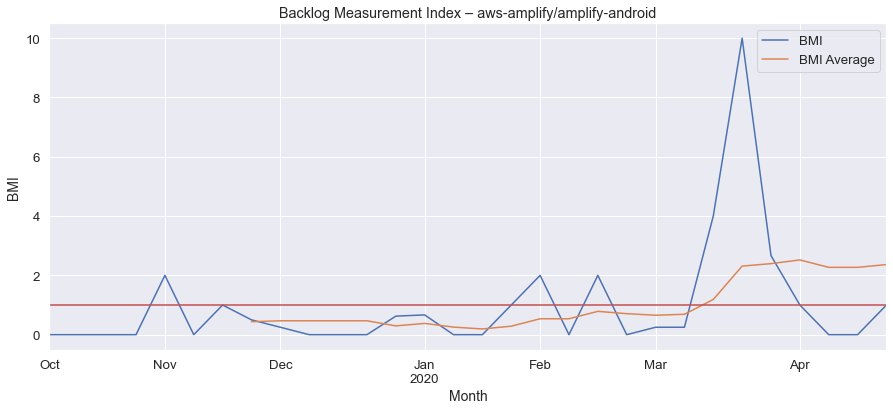

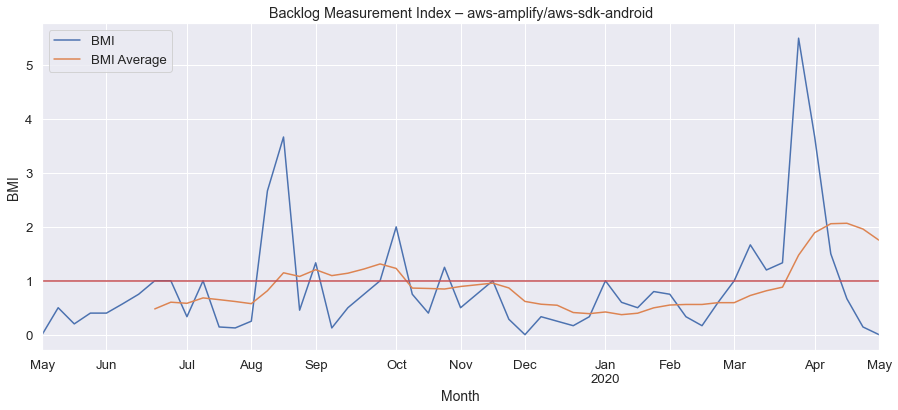

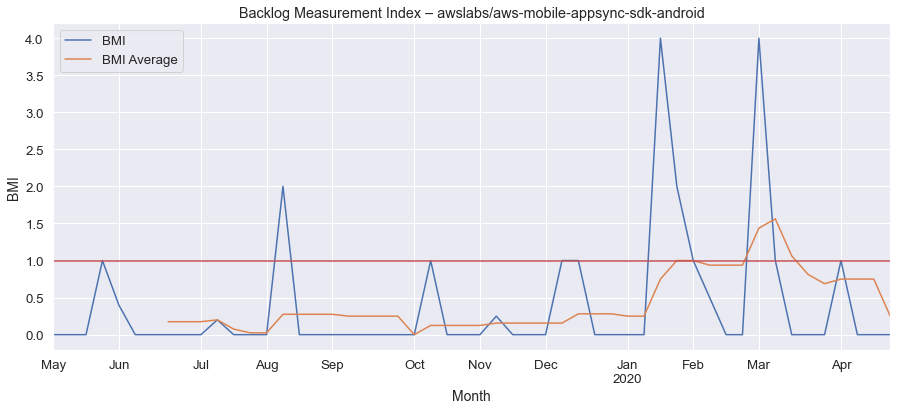

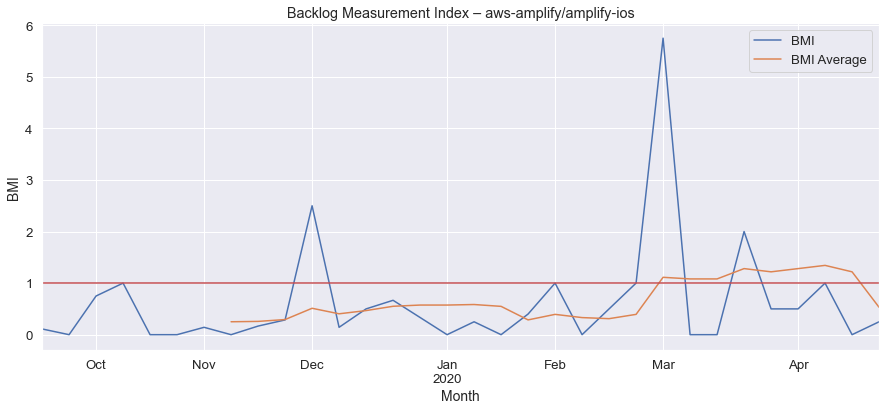

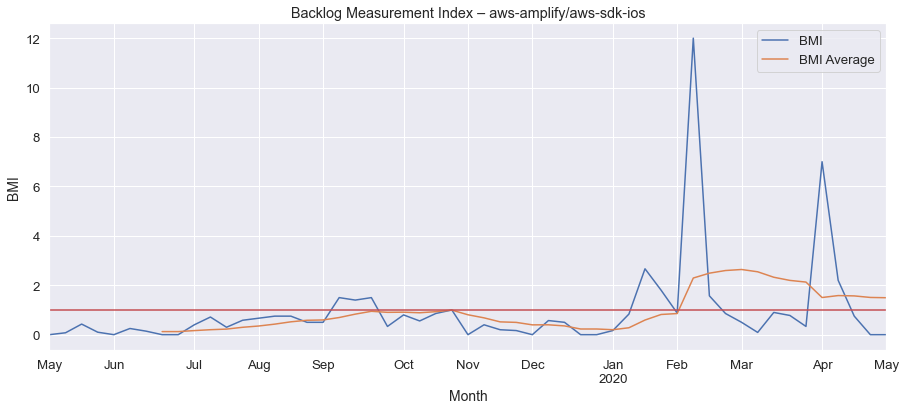

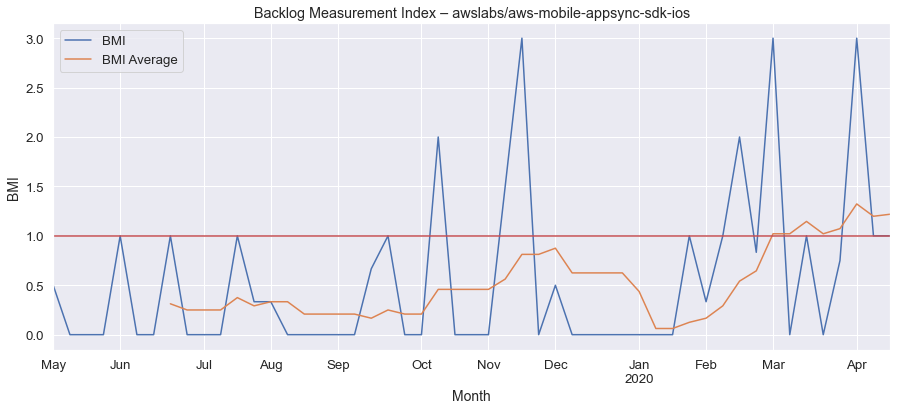

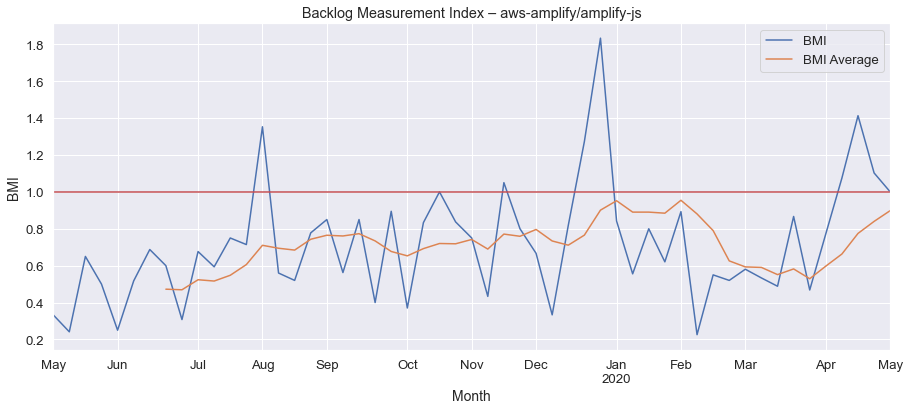

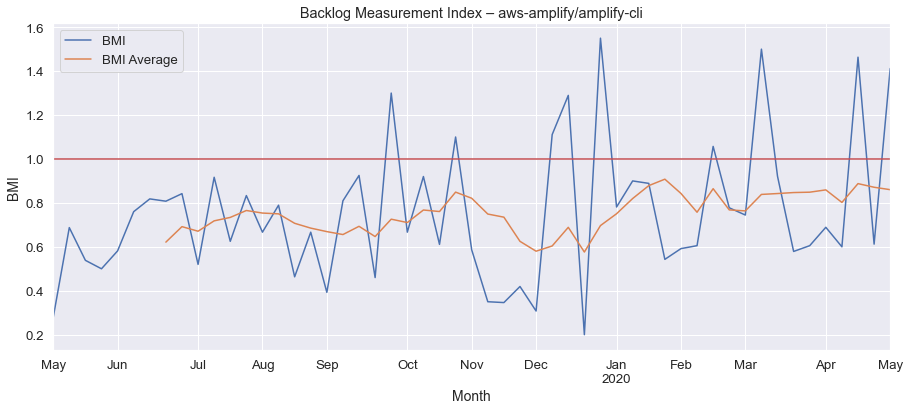

In [9]:
# Backlog Management Index

from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np
import pytz

now = datetime.utcnow().replace(tzinfo=pytz.utc)

sns.set(font_scale=1.2)
%matplotlib inline

for repo_name, df in repos.items(): 
    df = df.loc[df.created_at > now - timedelta(weeks=52)] 

    opened = df.set_index('created_at')
    opened = opened.id.resample('W', label='left').count().transpose().to_frame('count')
    closed = df.dropna().set_index('closed_at').sort_values(by='closed_at')
    closed = closed.id.resample('W', label='left').count().transpose().to_frame('count')

    both = opened.join(closed, how='outer', lsuffix='_opened', rsuffix='_closed')
    both.index = both.index.rename('date')
    both = both.rename(columns={'count_opened': 'Opened', 'count_closed': 'Closed'})

    both['Closed'] = both['Closed'].fillna(0)
    both['Opened'] = both['Opened'].fillna(0)
    both['BMI'] = both['Closed'] / both['Opened']
    both['BMI'] = both['BMI'].replace([np.inf, -np.inf], np.nan)
    both['BMI'] = both['BMI'].fillna(both['Closed'])

    both['BMI Average'] = both['BMI'].rolling(window=8).mean()

    ax = both[['BMI', 'BMI Average']].plot(kind='line', figsize=(15, 6), legend=True)
    ax.set_xlabel('Month', fontsize=14)
    ax.set_ylabel('BMI', fontsize=14)
    
    ax.set(title=f'Backlog Measurement Index – {repo_name}')
    
    plt.axhline(y=1.0, color='r', linestyle='-')
    plt.show()

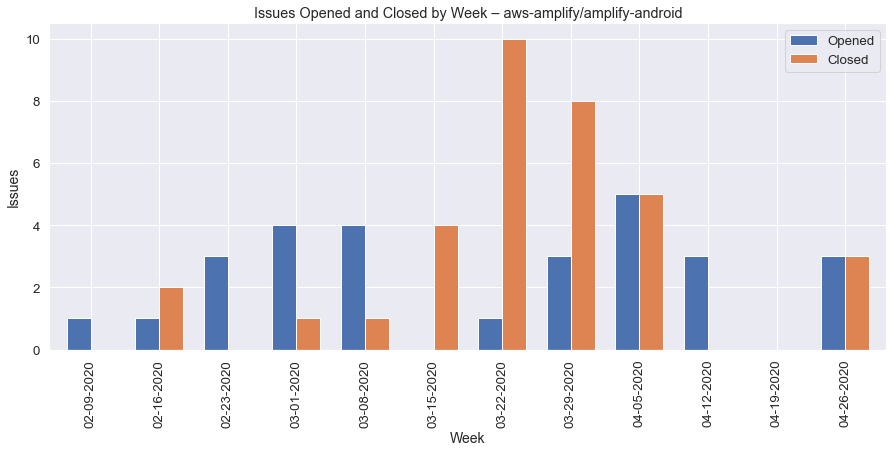

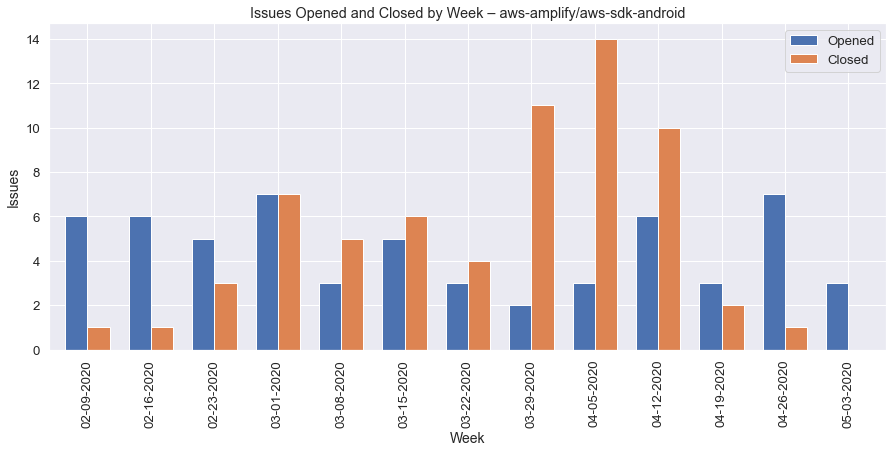

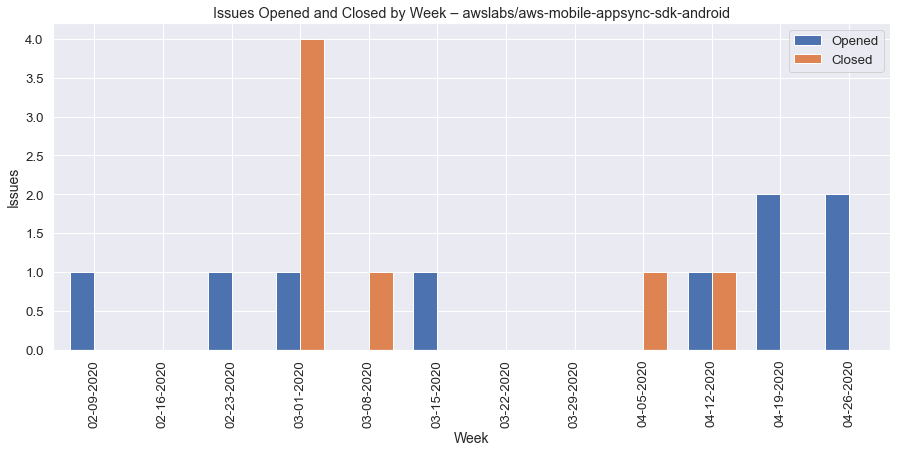

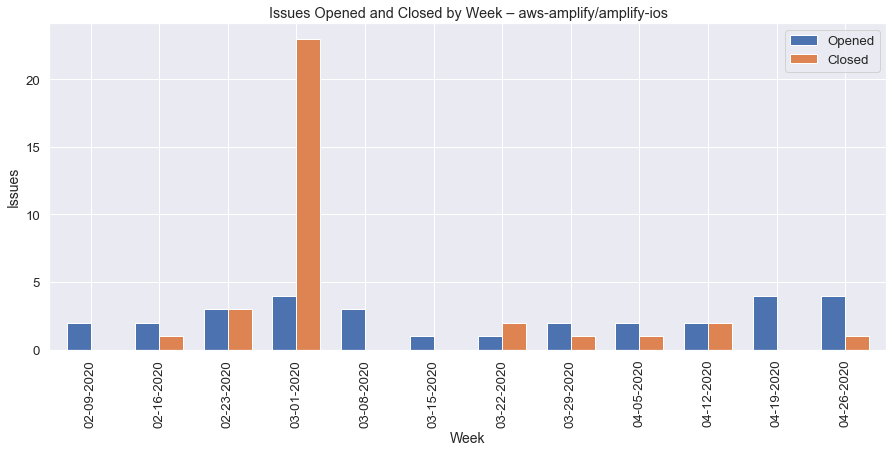

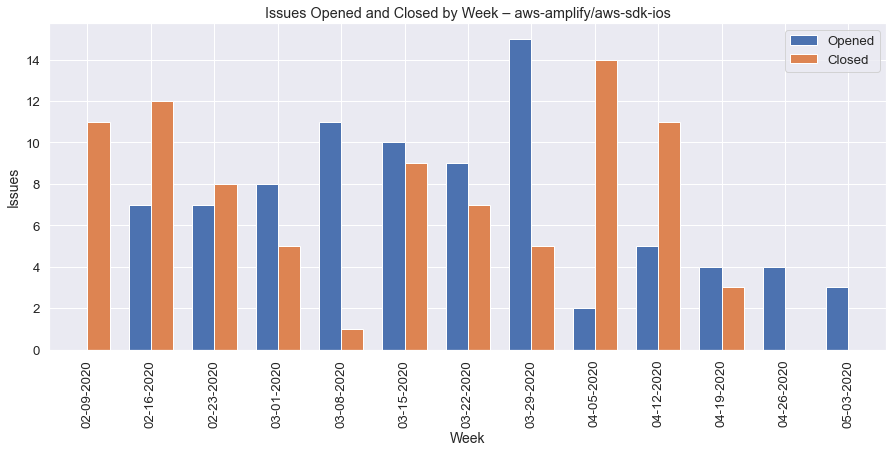

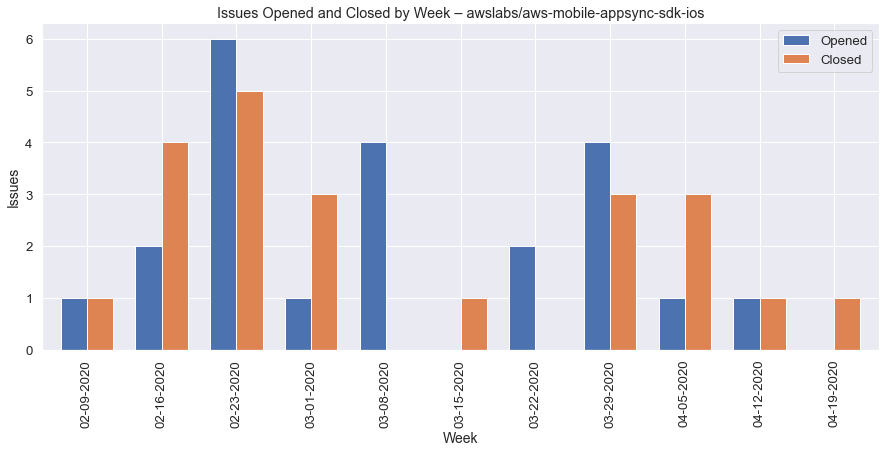

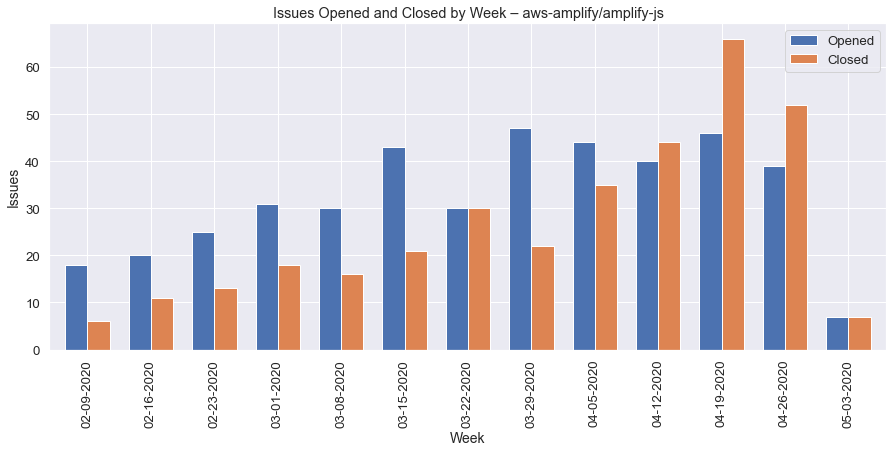

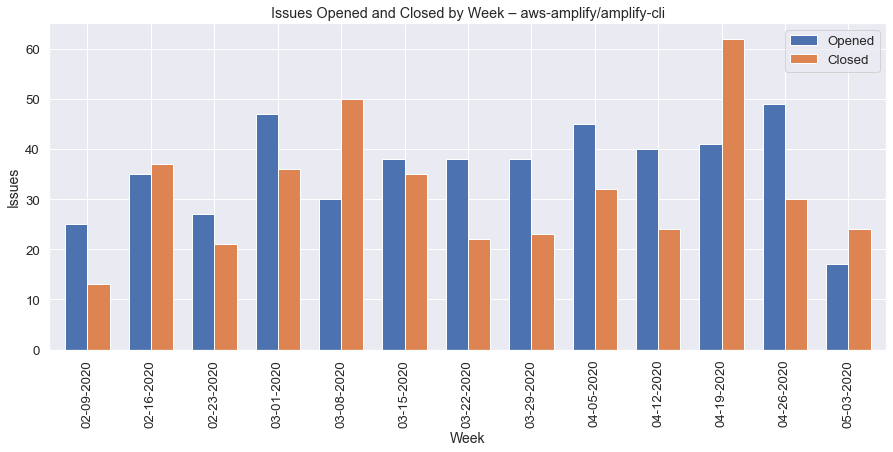

In [10]:
# Issues Opened and Closed by Week

from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np
import pytz

now = datetime.utcnow().replace(tzinfo=pytz.utc)

sns.set(font_scale=1.2)
%matplotlib inline

for repo_name, df in repos.items():
    opened = df.loc[(df.created_at > now - timedelta(weeks=12))] 
    closed = df.loc[(df.closed_at > now - timedelta(weeks=12))] 
    
    opened = opened.set_index('created_at')
    opened = opened.id.resample('W', label='left').count().transpose().to_frame('count')
    closed = closed.dropna().set_index('closed_at').sort_values(by='closed_at')
    closed = closed.id.resample('W', label='left').count().transpose().to_frame('count')

    both = opened.join(closed, how='outer', lsuffix='_opened', rsuffix='_closed')
    both.index = both.index.rename('date')
    both = both.rename(columns={'count_opened': 'Opened', 'count_closed': 'Closed'})
    ax = both[['Opened','Closed']].plot(kind='bar', width=0.7, figsize=(15, 6), legend=True)

    ax.set_xlabel('Week', fontsize=14)
    ax.set_ylabel('Issues', fontsize=14)
    ax.set_xticklabels(both.index.strftime('%m-%d-%Y'))
    ax.set(title=f'Issues Opened and Closed by Week – {repo_name}')
    
    plt.show()

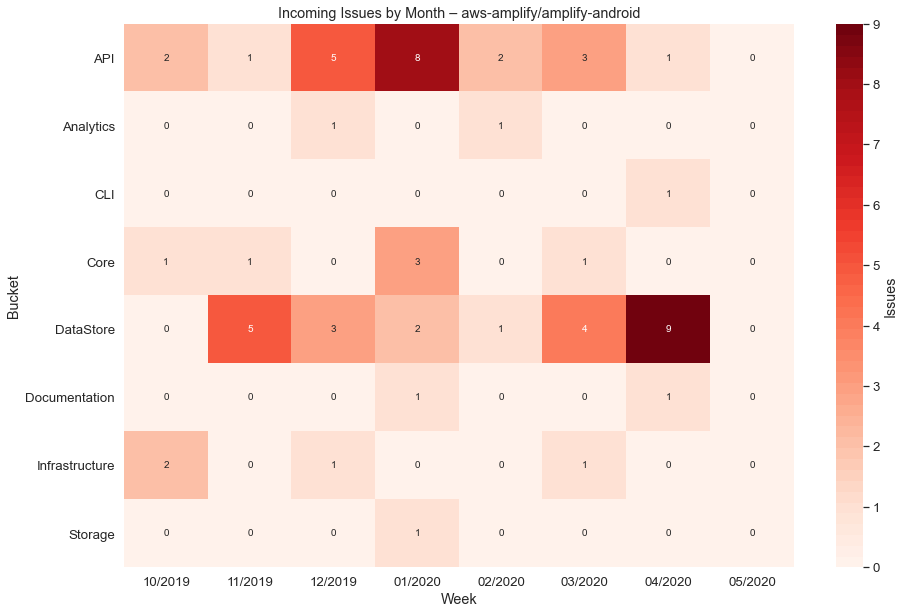

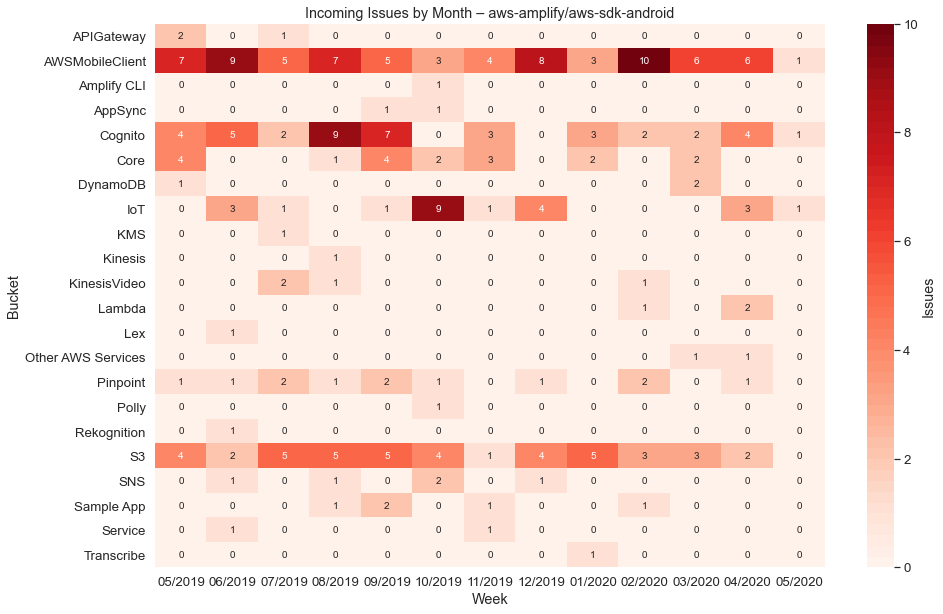

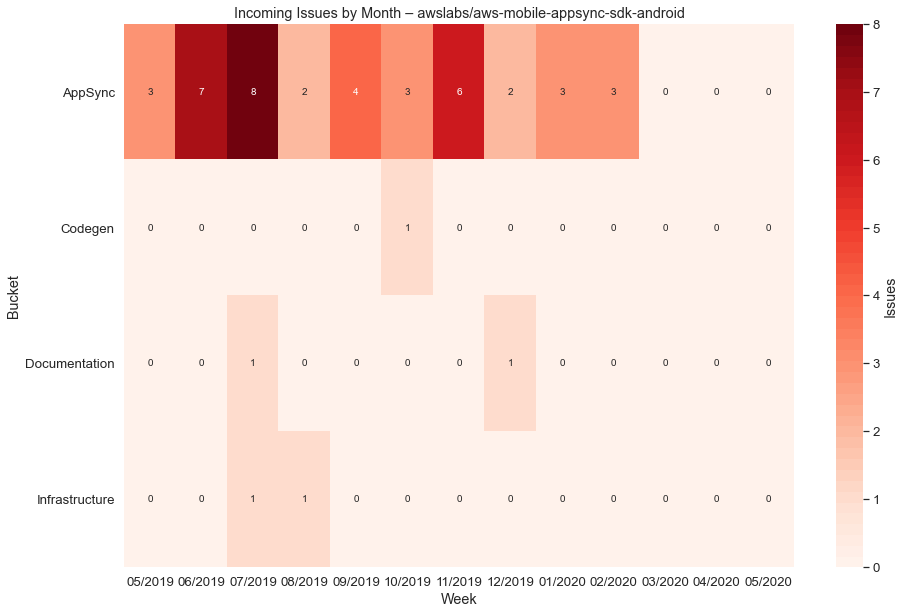

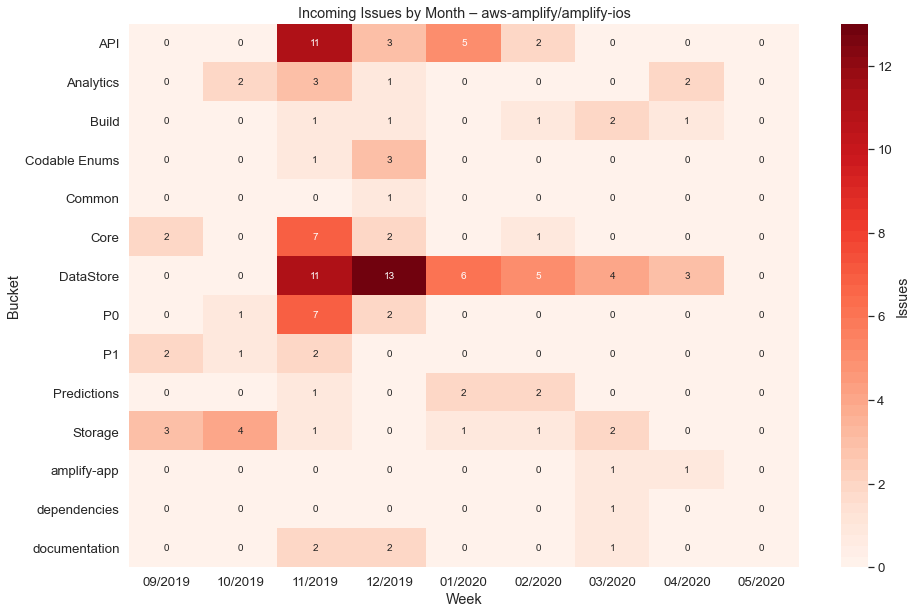

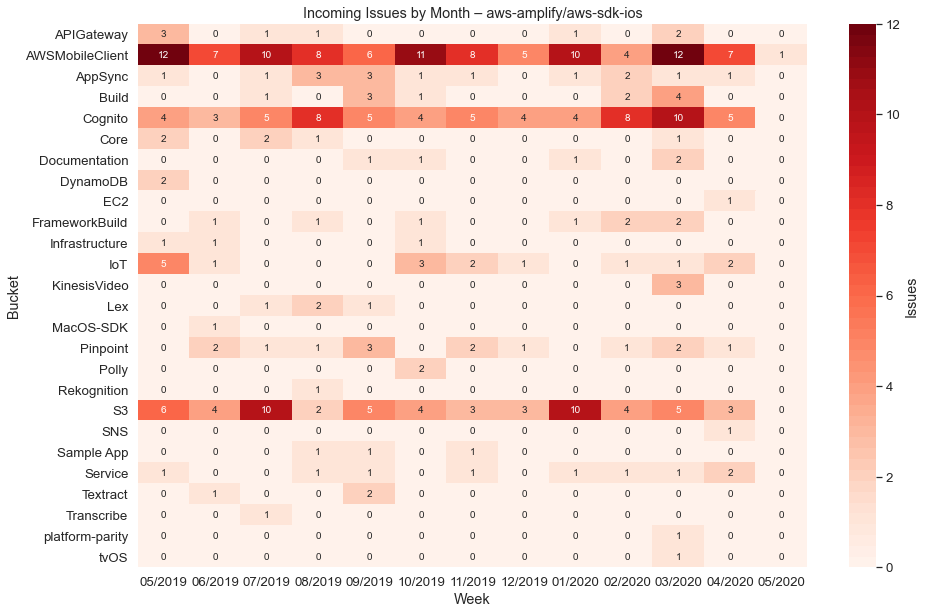

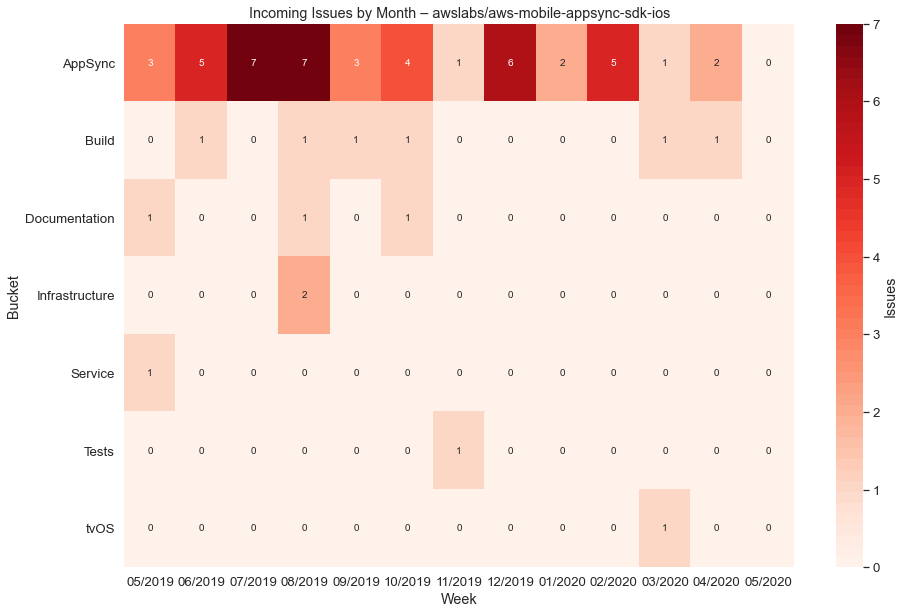

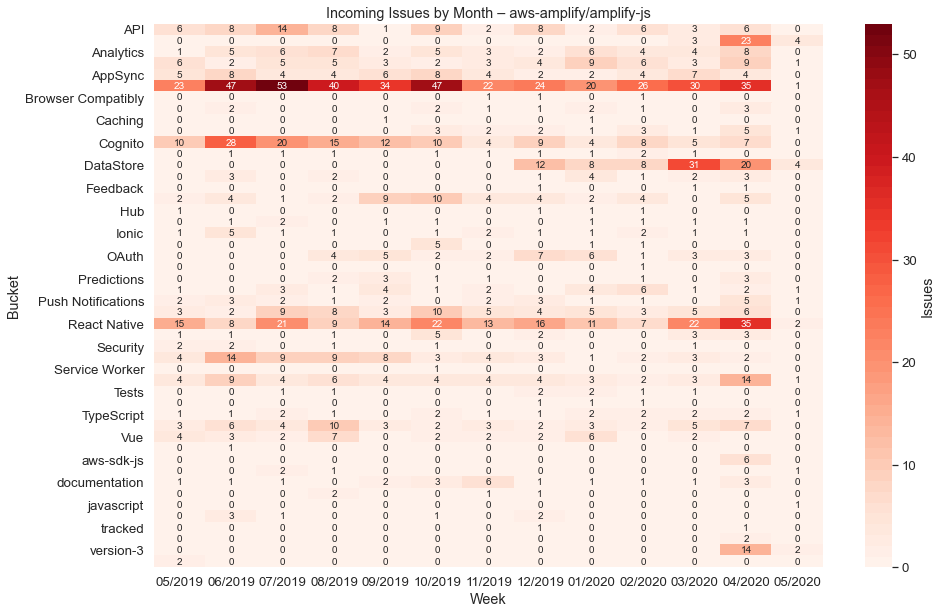

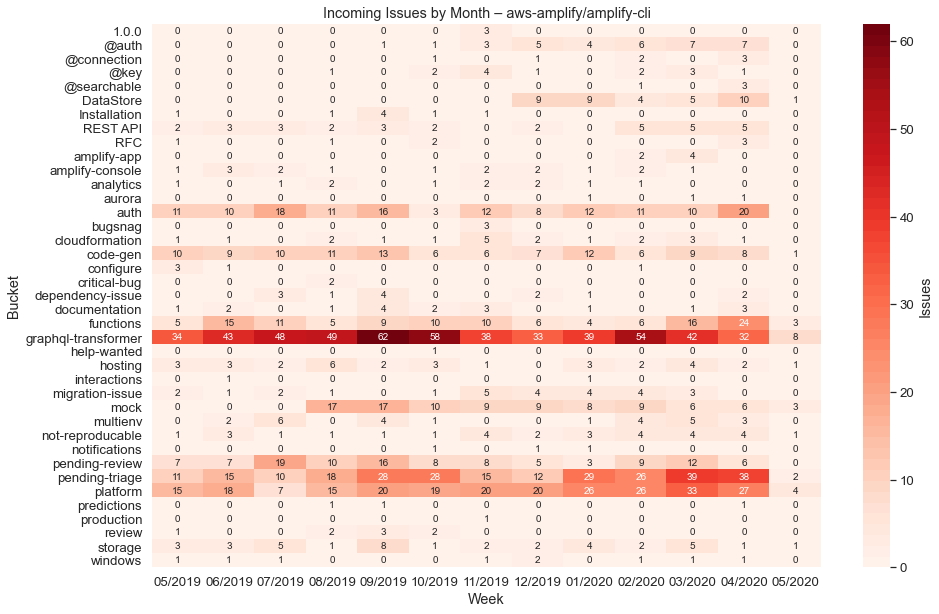

In [11]:
# Incoming Issues by Month

from datetime import datetime, timedelta, date
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pytz

now = datetime.utcnow().replace(tzinfo=pytz.utc)
idx = pd.date_range(now - timedelta(weeks=12), now, freq='W')   

sns.set(font_scale=1.2)

%matplotlib inline

for repo_name, df in repos.items():    
    df = df.loc[df.created_at > now - timedelta(weeks=52)] 
    df = df.loc[np.array(list(map(len, df.labels.values))) > 0]
    df = df.labels.apply(pd.Series).merge(df, left_index = True, right_index = True)
    df = df.drop(["labels"], axis = 1)
    df = df.melt(id_vars = ['id', 'title', 'bucket', 'created_at', 'closed_at', 'score'], value_name = 'label')
    df = df.dropna(subset=['label'])
    df = df.loc[df.label.apply(lambda l: l not in issue_buckets.keys())]
    df = df.loc[df.label.apply(lambda l: l not in omit_labels)]
    df = df.pivot(index='created_at', columns='label', values='created_at')
    df = pd.concat([df, pd.DataFrame(index=[date for date in idx])])    
    df = df.resample('M', label='right').count().transpose()
    
    if (len(df)):
        plt.subplots(figsize=(15, 10))

        dates = df.columns.strftime('%m/%Y').unique()
        ax = sns.heatmap(df, xticklabels=dates, cmap=sns.color_palette("Reds", 50), fmt='.0f', annot=True,
                         cbar_kws={'label': 'Issues'})

        ax.set(xlabel='Week', ylabel='Bucket', title=f'Incoming Issues by Month – {repo_name}')
        plt.yticks(rotation=0)
        plt.show()

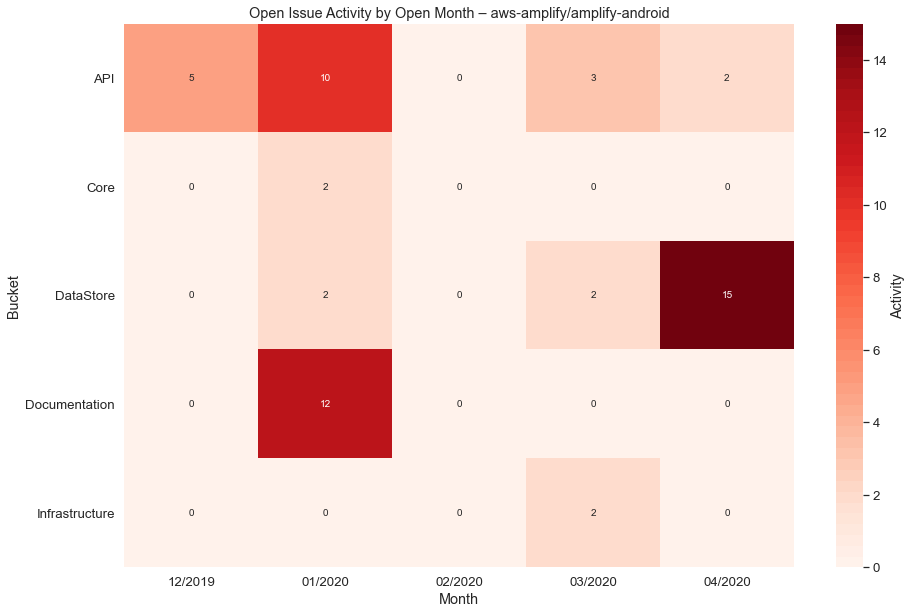

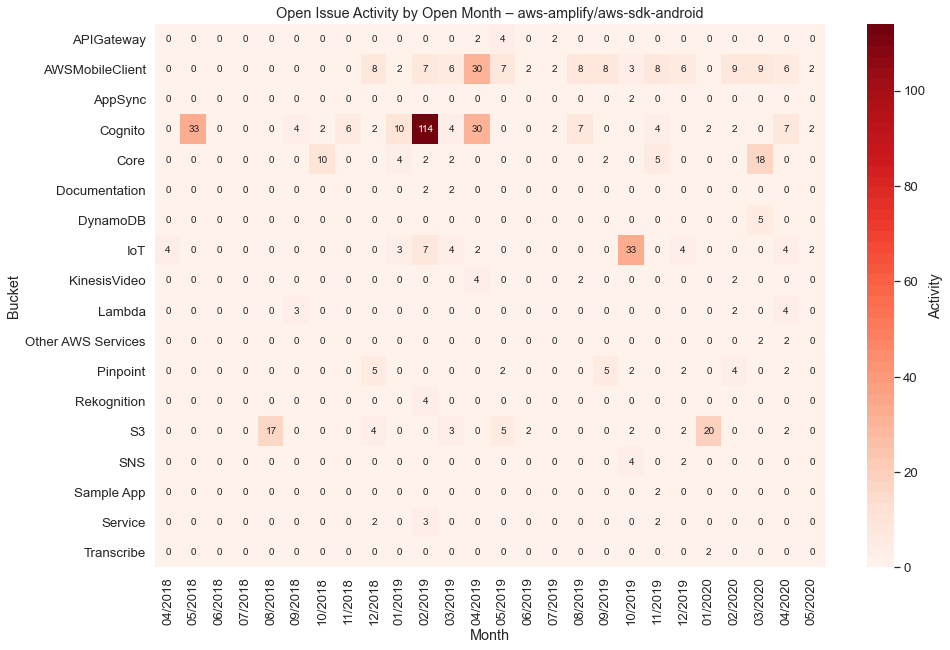

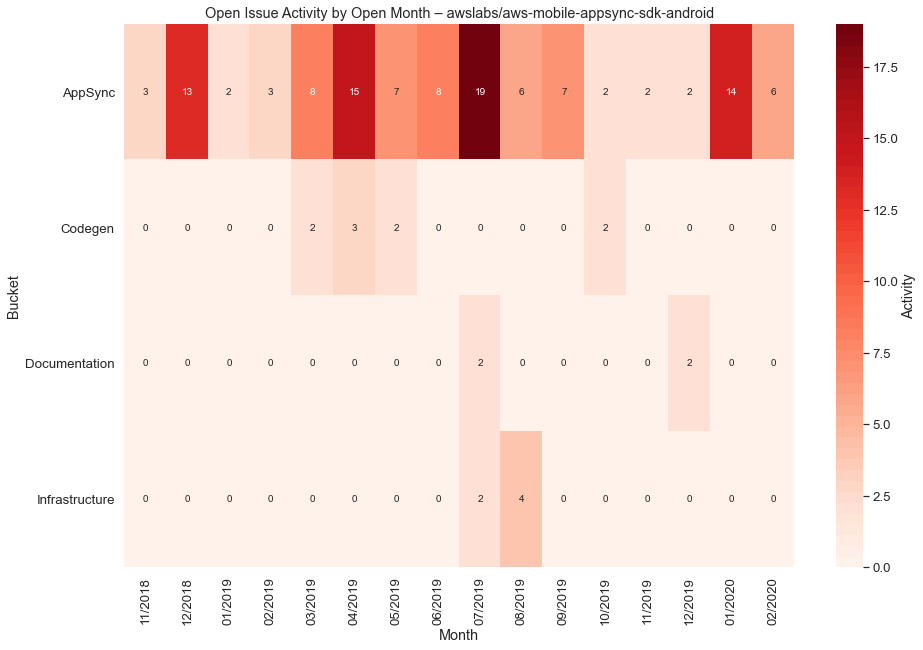

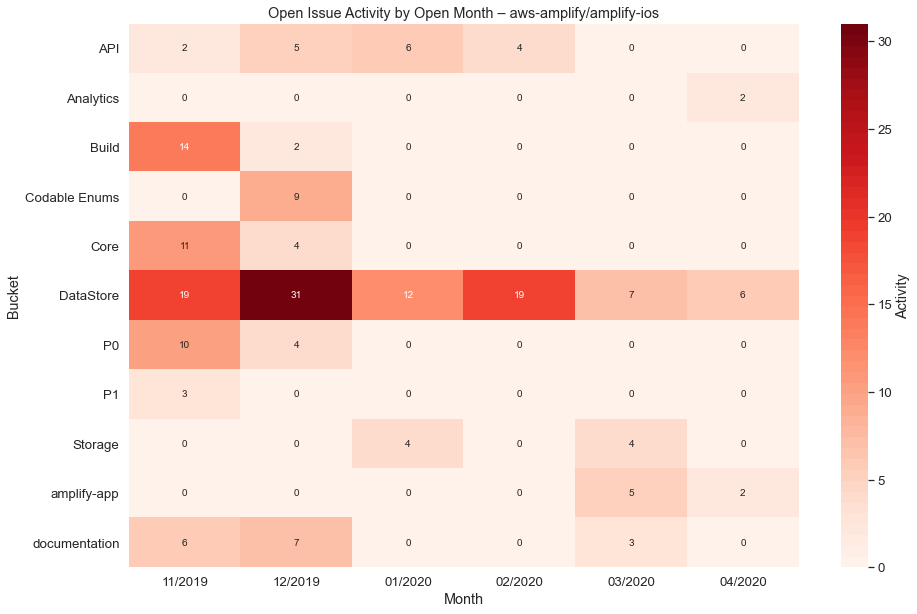

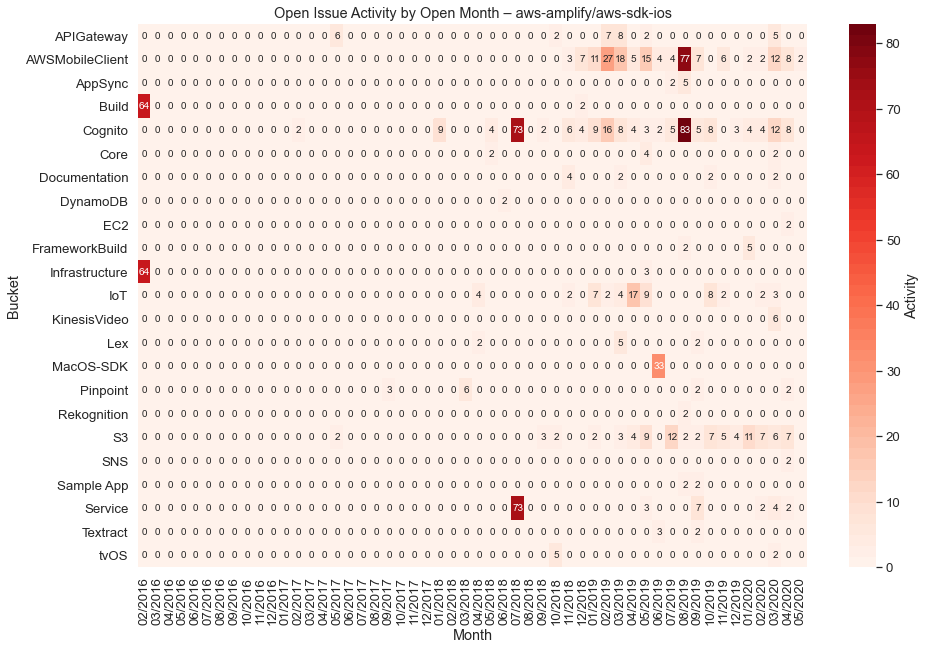

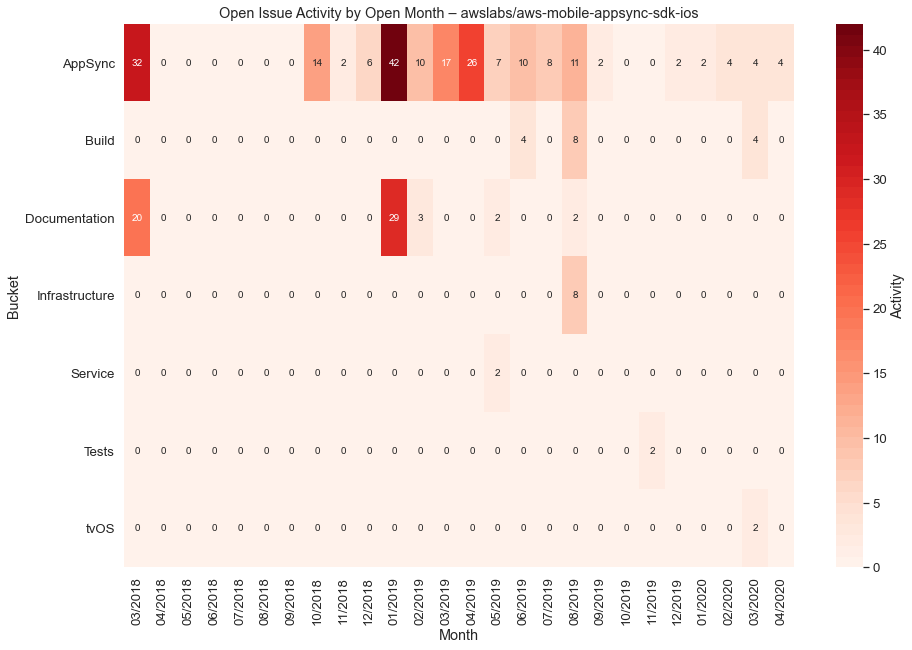

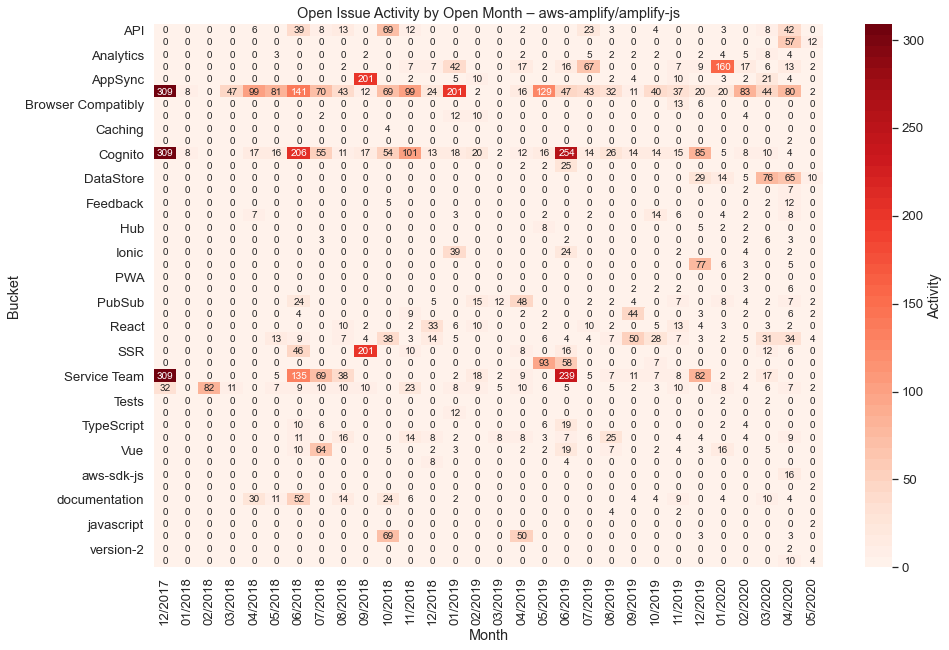

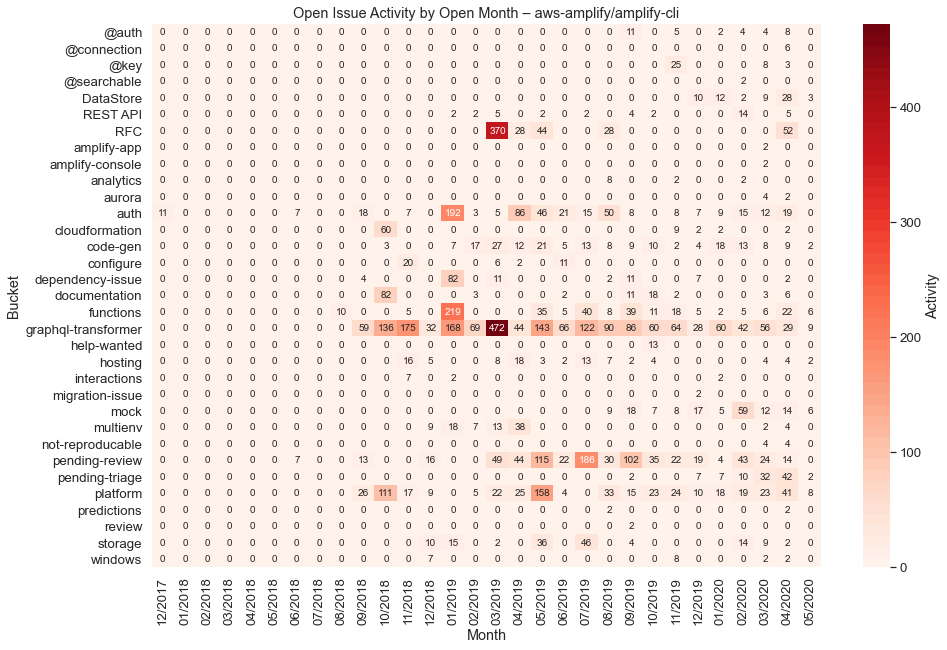

In [15]:
# Open Issues Activity by Open Month

from datetime import datetime, timedelta, date
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pytz

now = datetime.utcnow().replace(tzinfo=pytz.utc)

sns.set(font_scale=1.2)

%matplotlib inline

for repo_name, df in repos.items():
    plt.subplots(figsize=(15, 10))
    
    df = df[~(df.closed_at > '1970-01-01')]
    df = df.loc[np.array(list(map(len, df.labels.values))) > 0]
    df = df.labels.apply(pd.Series).merge(df, left_index = True, right_index = True)
    df = df.drop(["labels"], axis = 1)
    df = df.melt(id_vars = ['id', 'title', 'bucket', 'created_at', 'closed_at', 'score'], value_name = 'label')
    df = df.dropna(subset=['label'])
    df = df.loc[df.label.apply(lambda l: l not in issue_buckets.keys())]
    df = df.loc[df.label.apply(lambda l: l not in omit_labels)]
    df = df.pivot(index='created_at', columns='label', values='score')
    df = df.resample('M', label='right').sum().transpose()

    dates = df.columns.strftime('%m/%Y')
    ax = sns.heatmap(df, xticklabels=dates, cmap=sns.color_palette('Reds', 50), annot=True, fmt='.0f',
                     cbar_kws={'label': 'Activity'})
    ax.set(xlabel='Month', ylabel='Bucket', title=f'Open Issue Activity by Open Month – {repo_name}')

    plt.yticks(rotation=0)
    plt.show()

In [13]:
from datetime import datetime
from IPython.display import display, HTML

total = (datetime.now() - start).seconds
minutes, seconds = divmod(total, 60)

if minutes:
    display(HTML(f'<em>Report generation took {minutes}min, {seconds}sec'))
else:
    display(HTML(f'<em>Report generation took {seconds}sec'))